# Time series analysis of sensor data

Load necessary libraries:

In [2]:
from influxdb import DataFrameClient
from matplotlib.dates import HourLocator, DateFormatter
import pandas as pd

## influxdb

Connect to the influxDB instance with the sensor data

In [3]:
client = DataFrameClient('192.168.1.199', 8086, '', '', 'home_assistant')

Query for the entity required with any time filtering.

In [13]:
result = client.query('''
SELECT
    entity_id as sensor, time, value
FROM "°C" 
WHERE (entity_id = 'laundry_temperature') 
--OR entity_id = 'pip_temperature'
--OR entity_id = 'attic_office_temperature')
AND time >= '2021-02-10'
tz('Europe/London')
''')
df=result['°C']
print(df.shape)
df.head()

(503, 2)


,sensor,value
2021-02-10 00:03:54.363758+00:00,laundry_temperature,6.63
2021-02-10 00:23:28.113000+00:00,laundry_temperature,6.53
2021-02-10 00:53:00.220548+00:00,laundry_temperature,6.43
2021-02-10 01:32:29.315599+00:00,laundry_temperature,6.30
2021-02-10 02:11:58.941212+00:00,laundry_temperature,6.22


In [14]:
df.tail()

,sensor,value
2021-02-22 18:30:02.040585+00:00,laundry_temperature,13.52
2021-02-22 19:49:19.799555+00:00,laundry_temperature,13.34
2021-02-22 20:08:51.031935+00:00,laundry_temperature,13.24
2021-02-22 20:38:22.118768+00:00,laundry_temperature,13.15
2021-02-22 20:57:54.365640+00:00,laundry_temperature,13.23


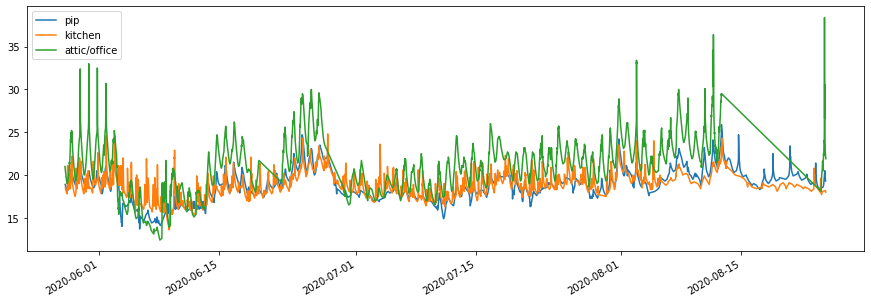

In [24]:
ax = df[df.sensor == 'pip_temperature'].plot(figsize=[15,5])
df[df.sensor == 'kitchen_temperature'].plot(ax=ax)
df[df.sensor == 'attic_office_temperature'].plot(ax=ax)
ax.legend(['pip','kitchen','attic/office']);

In [5]:
#df.pivot(columns='sensor').head()

In [6]:
#df.pivot(columns='sensor').plot(figsize=[15,5])

### Daily stats

**How many measurements per day?**

In [7]:
#df.groupby(['sensor']).resample('D').count().head()
#df.groupby(['sensor']).resample('D').count().unstack(level=0).mean().sensor

In [15]:
df.pivot(columns='sensor').resample('D').count().head()

,value
sensor,laundry_temperature
2021-02-10 00:00:00+00:00,29
2021-02-11 00:00:00+00:00,58
2021-02-12 00:00:00+00:00,51
2021-02-13 00:00:00+00:00,33
2021-02-14 00:00:00+00:00,36


In [9]:
df.pivot(columns='sensor').resample('D').count().mean()

       sensor                  
value  attic_office_temperature    38.844444
       kitchen_temperature         29.288889
       pip_temperature             15.711111
dtype: float64

**Average daily temperature**

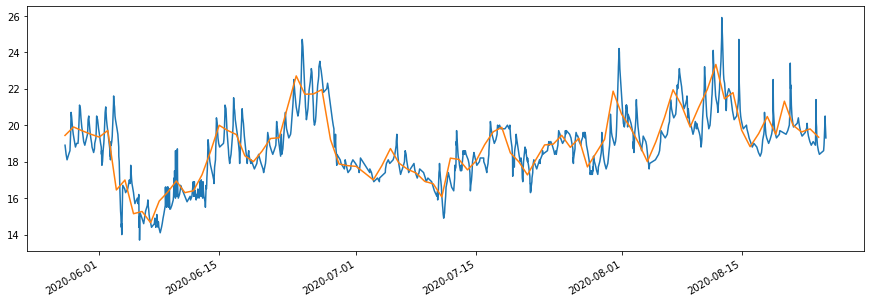

In [10]:
# replot raw data
ax = df[df.sensor == 'pip_temperature'].plot(figsize=[15,5],legend=False)
# overlay average (mean)
df[df.sensor == 'pip_temperature'].resample('D').mean().plot(legend=False,figsize=[15,5],ax=ax);

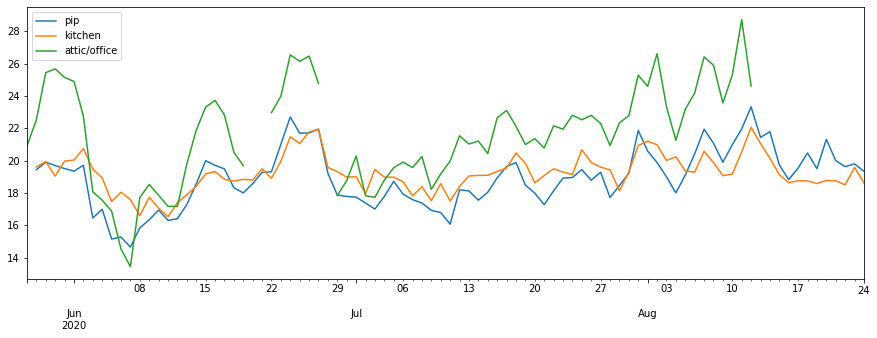

In [11]:
ax = df[df.sensor == 'pip_temperature'].resample('D').mean().plot(legend=False,figsize=[15,5])
df[df.sensor == 'kitchen_temperature'].resample('D').mean().plot(legend=False,figsize=[15,5],ax=ax)
df[df.sensor == 'attic_office_temperature'].resample('D').mean().plot(legend=False,figsize=[15,5],ax=ax)
ax.legend(["pip","kitchen","attic/office"]);

**Average hourly temperature**

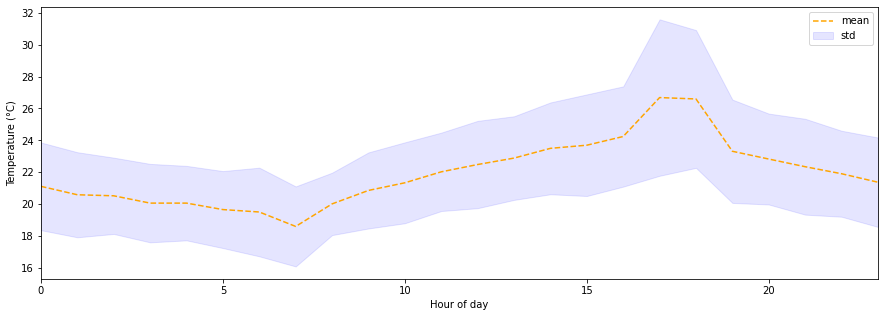

In [12]:
hourly = df[df.sensor == 'attic_office_temperature'].groupby([df[df.sensor == 'attic_office_temperature'].index.hour])
ax = hourly.mean().plot(figsize=[15,5],color='orange',style=['--'])
ax.fill_between(list(range(0,24)), (hourly.mean() - hourly.std()).values.transpose()[0], (hourly.mean() + hourly.std()).values.transpose()[0],color='b', alpha=.1)
ax.legend(["mean","std"])
ax.set_xlim([0,23])
ax.set_xlabel("Hour of day")
ax.set_ylabel("Temperature (°C)");

### How often were measurements taken?

Calculate the difference in time between measurements

In [13]:
df2 = df[df.sensor == 'pip_temperature']

df2.reset_index(inplace=True)
df2['diff']=df2['index'].diff()
df2.set_index('index',inplace=True)
df2.head()

/home/amadeus/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,sensor,value,diff
index,,,
2020-05-28 00:08:52.615111+00:00,pip_temperature,18.9,NaT
2020-05-28 01:48:22.275558+00:00,pip_temperature,18.6,0 days 01:39:29.660447
2020-05-28 03:07:55.504744+00:00,pip_temperature,18.4,0 days 01:19:33.229186
2020-05-28 05:47:14.571906+00:00,pip_temperature,18.1,0 days 02:39:19.067162
2020-05-28 10:26:17.323261+00:00,pip_temperature,18.4,0 days 04:39:02.751355


In [14]:
# Average gap between readings
df2['diff'].mean()

Timedelta('0 days 01:30:32.310959422')

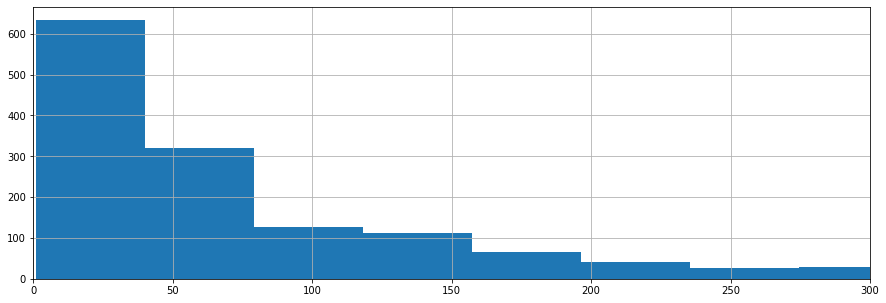

In [15]:
ax = df2['diff'].astype('timedelta64[m]').hist(figsize=[15,5],bins=40)
#ax.set_xlim([0,ax.get_xlim()[1]])
ax.set_xlim([0,300]);

<AxesSubplot:xlabel='index'>

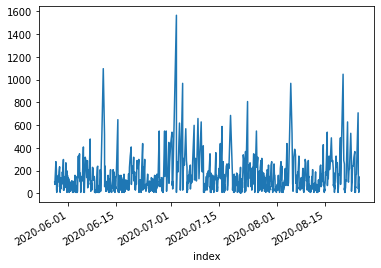

In [16]:
df2['diff'].astype('timedelta64[m]').plot()

## Heater

### Electric

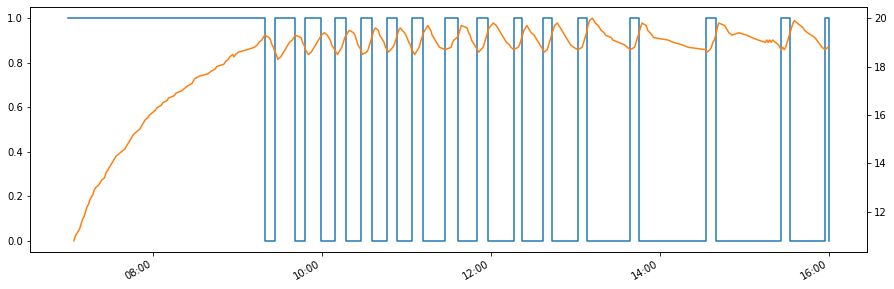

In [17]:
result = client.query('''
SELECT
    time, value
FROM "switch.attic_electric_heater"
WHERE time > '2020-05-10'
AND time <= '2020-05-12'
tz('Europe/London')
''')
df = result["switch.attic_electric_heater"]
ax = df.plot(kind='line',drawstyle='steps-post',figsize=(15,5),legend=False)
ax.xaxis.set_major_locator(HourLocator(interval=2)) # tick every two hours
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

result = client.query('''
SELECT
    time, value
FROM "°C" 
WHERE entity_id = 'attic_office_temperature' 
AND time > '2020-05-11 08:00:00'
AND time <= '2020-05-11 17:00:00'
tz('Europe/London')
''')
df=result['°C']
df.plot(figsize=(15,5),legend=False,ax=ax,secondary_y=True);

### Boiler impact

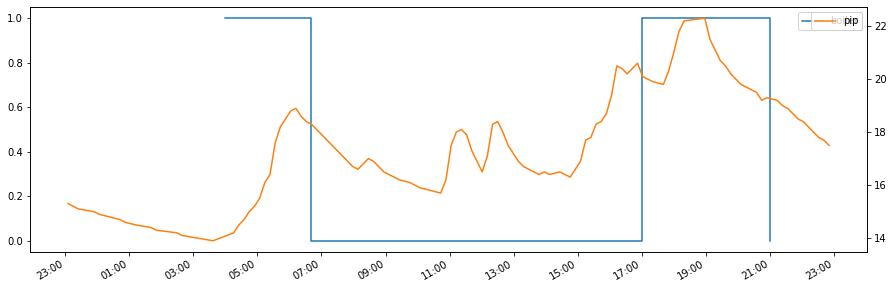

In [18]:
result = client.query('''
SELECT
    time, value
FROM "switch.tasmota"
WHERE time > '2020-05-12'
AND time < '2020-05-13'
tz('Europe/London')
''')
df = result["switch.tasmota"]
ax = df.plot(kind='line',drawstyle='steps-post',figsize=(15,5),legend=False)
ax.xaxis.set_major_locator(HourLocator(interval=2)) # tick every two hours
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

result = client.query('''
SELECT
    time, value
    FROM "switch.pip_s_heater"
WHERE time > '2020-05-12'
AND time < '2020-05-13'
tz('Europe/London')
''')
df = result["switch.pip_s_heater"]
#df.plot(kind='line',drawstyle='steps-post',legend=False,ax=ax)
ax.xaxis.set_major_locator(HourLocator(interval=2)) # tick every two hours
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))


result = client.query('''
SELECT
    time, value
FROM "°C" 
WHERE entity_id = 'pip_temperature' 
AND time > '2020-05-12'
AND time < '2020-05-13'
tz('Europe/London')
''')
df=result['°C']
#df.plot(legend=False,ax=ax,secondary_y=True)

result = client.query('''
SELECT
    time, value
FROM "°C" 
WHERE entity_id = 'kitchen_temperature' 
AND time > '2020-05-12'
AND time < '2020-05-13'
tz('Europe/London')
''')
df=result['°C']
df.plot(legend=False,ax=ax,secondary_y=True)
ax.legend(['boiler','pip'])
ax.right_ax.legend(['pip','kitchen']);

## Battery discharge

                                  value
2020-08-24 22:22:50.533398+01:00   3.45


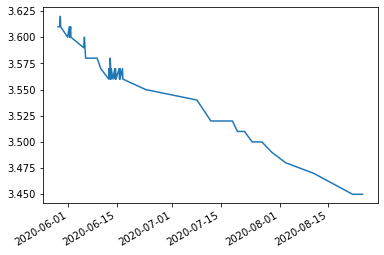

In [19]:
result = client.query('''
SELECT
    time, value
FROM V
WHERE entity_id = 'pip_vcc' 
AND time >= '2020-05-28'
tz('Europe/London')
''')
df=result['V']
#append last known value to current time
ts = pd.Timestamp.now(tz="Europe/London")
val = df.value.tail(1).values
new_row = pd.DataFrame(val, columns = ["value"], index=[ts])
df = pd.concat([df, new_row], ignore_index=False)
df.plot(kind='line',legend=False)
print(df.tail(1))

### Uptime

In [20]:
date_range = df.tail(1).index.astype('datetime64[ns]') - df.head(1).index.astype('datetime64[ns]')
print(date_range.days.values[0],"days")

87 days


## Days left (linear)

In [21]:
rate = (df.value.max() - df.value.min()) / date_range.days

In [22]:
print((df.value.min() - 2.8)/rate.values[0],"days")
print(((df.value.min() - 2.8)/rate.values[0])/(365/12),"months")

332.64705882352973 days
10.936341659951662 months
